In [142]:
import time
import pandas as pd
import numpy as np
import util
import pyBigWig
import seaborn as sns
import glob
from matplotlib_venn import venn2,venn3
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
source='data/source/'
tic=time.time()

def get_cg(x):
    cg=set(range(x['b'],x['e']))
    cg=ind[x['ch']].intersection(cg)
    return cg
def hmr2df(hmr):
    gs=pd.read_table(hmr,header=None,usecols=[0,1,2])
    gs=gs[~gs[0].isin(['chrX','chrY','chrM'])]
    print(len(gs),end=',')
    gs.columns=['ch','b','e']   
    gs['d']=gs['e']-gs['b']
    gs['r']=gs.apply(lambda x:get_cg(x) ,axis=1)
    gs['rd']=gs.r.apply(lambda x:len(x))
    gs.index=gs['ch']+'_'+gs['b'].astype(str)
    gg=gs.groupby('ch')['r'].apply(list)
    gg=gg.apply(lambda x:set.union(*x))    
    return (gs,gg)   
def get_ts(x):
    chrom=x['ch']
    com=set(range(x['b'],x['e'])).intersection(expg[chrom])
    if len(com)>0:
        ts=list(com)[0]
        ts=exp.loc[(exp['chrom']==int(chrom[3:])) & (exp.ts==ts)].index.values[0]
    else:
        ts=np.nan
    return(ts)

In [2]:
ind=pd.read_table('data/meth/h/Human_H1.meth',engine='c',usecols=[0,1],header=None)
ind=ind.groupby(0)[1].apply(list)
ind=ind.apply(lambda x:set(x))

In [129]:
samples=['s','t','h']
c={}
cg={}
cu={}
cug={}

In [143]:
for s in samples:
    c[s],cg[s]=hmr2df('data/meth/'+s+'/'+s+'.hmr')

95351,52648,39517,

In [144]:
c['t']['s']=c['t'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r'])),1)
c['t']['sh']=c['t'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r']).intersection(cg['h'][x['ch']])),1)
c['s']['t']=c['s'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r'])),1)
c['s']['th']=c['s'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r']).intersection(cg['h'][x['ch']])),1)

In [145]:
c['h']['t']=c['h'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r'])),1)
c['h']['s']=c['h'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r'])),1)

In [146]:
print(round(c['t']['rd'].sum()/10**3),
      round(c['t']['s'].sum()/10**3),
      round(c['t'][c['t']['s']>0]['sh'].sum()/10**3))
print(round(c['s']['rd'].sum()/10**3),
      round(c['s']['t'].sum()/10**3),
      round(c['s'][c['s']['t']>0]['th'].sum()/10**3))

2609 2352 2144
3486 2352 2144


In [179]:
ct,cs,ch=[],[],[]
for i,r in c['t'].iterrows():
    for j in list(r['r']):
        ct.append(r['ch']+'_'+str(j))
for i,r in c['s'].iterrows():
    for j in list(r['r']):
        cs.append(r['ch']+'_'+str(j)) 
for i,r in c['h'].iterrows():
    for j in list(r['r']):
        ch.append(r['ch']+'_'+str(j))        

In [180]:
pd.DataFrame(ct).to_csv('data/t.csv',index=False,header=False)
pd.DataFrame(cs).to_csv('data/s.csv',index=False,header=False)
pd.DataFrame(ch).to_csv('data/h.csv',index=False,header=False)

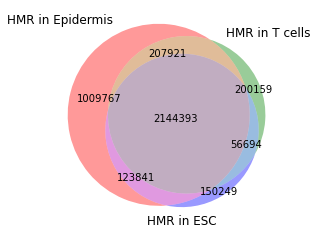

In [182]:
subsets=(set(cs),set(ct),set(ch))
v=venn3(subsets = subsets, set_labels = ('HMR in Epidermis', 'HMR in T cells','HMR in ESC'))

In [157]:
for s in ['s','t']:
    for n in ['y','o']:
        path='data/meth/'+s+'/'+n+'.bw'
        bw=pyBigWig.open(path)
        c[s][n]=c[s].apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
    c[s]['dd']=c[s]['o']-c[s]['y']
    cu[s]=c[s][c[s]['dd']>.1]
    cug[s]=cu[s].groupby('ch')['r'].apply(list)
    cug[s]=cug[s].apply(lambda x:set.union(*x))                   

In [158]:
cu['t']['su']=cu['t'].apply(lambda x:len(cug['s'][x['ch']].intersection(x['r'])),1)
cu['t']['suh']=cu['t'].apply(lambda x:len(cug['s'][x['ch']].intersection(cg['h'][x['ch']]).intersection(x['r'])),axis=1)
cu['s']['tu']=cu['s'].apply(lambda x:len(cug['t'][x['ch']].intersection(x['r'])),1)
cu['s']['tuh']=cu['s'].apply(lambda x:len(cug['t'][x['ch']].intersection(cg['h'][x['ch']]).intersection(x['r'])),axis=1)

In [159]:
print(round(cu['t'].rd.sum()/10**3),
      round(cu['t']['su'].sum()/10**3),
      round(cu['t'][cu['t']['su']>0]['suh'].sum()/10**3))
print(round(cu['s'].rd.sum()/10**3),
      round(cu['s']['tu'].sum()/10**3),
      round(cu['s'][cu['s']['tu']>0]['tuh'].sum()/10**3))

259 27 15
95 27 15


In [170]:
ct,cs,=[],[]
for i,r in cu['t'].iterrows():
    for j in list(r['r']):
        ct.append(r['ch']+'_'+str(j))
for i,r in cu['s'].iterrows():
    for j in list(r['r']):
        cs.append(r['ch']+'_'+str(j)) 

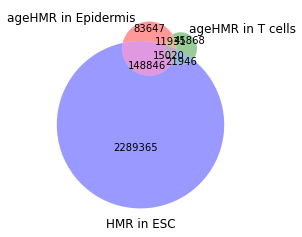

In [173]:
subsets=(set(ct),set(cs),set(ch))
venn3(subsets = subsets, set_labels = ('ageHMR in Epidermis', 'ageHMR in T cells','HMR in ESC'))

In [183]:
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
ts=cu['t'][cu['t']['su']>0]
st=cu['s'][cu['s']['tu']>0]
bs=[]
for i,r in ts.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
ts['ez']=bs    
bs=[]
for i,r in st.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
st['ez']=bs    

In [184]:
print(ts[ts.suh==0].ez.mean(),ts[ts.suh>0].ez.mean())
print(st[st.tuh==0].ez.mean(),st[st.tuh>0].ez.mean())

2.892130427157452 40.63913004243051
2.9151432654522944 40.820904419018945


In [185]:
ts['suhb']=ts['suh']>0
st['tuhb']=st['tuh']>0

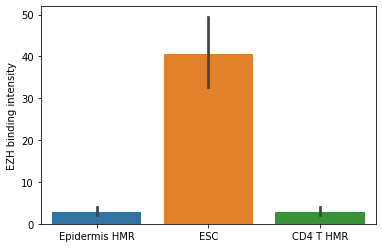

In [205]:
tst=ts.append(st[~st.tuhb])
tst.loc[tst.tuhb==False,'group']='CD4 T HMR'
tst.loc[tst.suhb==False,'group']='Epidermis HMR'
tst=tst.fillna('ESC')
ax=sns.barplot(data=tst[['group','ez']],x='group',y='ez')
ax.set(xlabel='',ylabel='EZH binding intensity');

In [193]:
h=c['h'].copy()

In [194]:
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
bs=[]
for i,r in h.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
h['ez']=bs

In [195]:
for s in ['s','f','t']:
    for n in ['y','o']:
        path='data/meth/'+s+'/'+n+'.bw'
        bw=pyBigWig.open(path)
        h[s+n]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
    h[s+'d']=h[s+'o']-h[s+'y']

In [200]:
h.loc[h.ez>100,'ezg']='High'
h.loc[(h.ez>10)&(h.ez<100),'ezg']='Moderate'
h.loc[h.ez<10,'ezg']='Low'

In [201]:
pl=h[['ezg','ty','to']].melt('ezg')
pl.columns=['ezg','T cell','value']
pl.head(1)

,ezg,T cell,value
0,Low,ty,0.003165


In [202]:
pl['T cell']=pl['T cell'].replace({'ty':'Young','to':'Old'})

[Text(0.5, 0, 'EZH Binding Level'), Text(0, 0.5, 'DNA Methylation')]

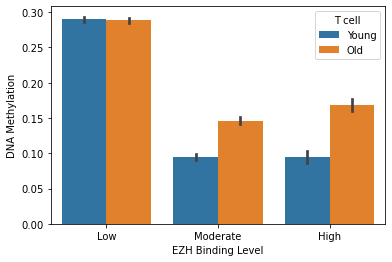

In [203]:
ax=sns.barplot(data=pl,x='ezg',y='value',hue='T cell')
ax.set(xlabel='EZH Binding Level', ylabel='DNA Methylation')

In [22]:
fs=['SRR3264'+str(i) for i in [413,414,415,416,722]]
for sn in fs:
    path='data/meth/f/'+sn+'.bw'
    bw=pyBigWig.open(path)
    h[sn]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)

In [23]:
sp=['SRR10429'+ i for i in  ['03','06','07','09','11','13']]
se=['SRR10429'+ i for i in  ['04','05','08','10','12','14']]
sep=sp+se
for sn in sep:
    path='data/meth/s/'+sn+'.bw'
    bw=pyBigWig.open(path)
    h[sn]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)

In [30]:
fyo=['Young-381','Young-400','Young-498','Old-247','Old-602','Old-725']
for sn in fs:
    path='data/meth/f/yo/'+sn+'.bw'
    bw=pyBigWig.open(path)
    h[sn]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)

In [32]:
hz=h[h.ez>100].copy()
print(len(hz),len(hz[hz.td>0]))

1035 972


In [33]:
tss=pd.read_csv('data/tss.csv',index_col=0)
exp=pd.read_csv('data/exp.csv',index_col=0)
exp['ch']='chr'+exp['chrom'].astype(str)
expg=exp.groupby('ch')['ts'].apply(list)
hz['ts']=hz.apply(lambda x: get_ts(x),axis=1)
hzt=hz[hz.ts.notna()]
len(hzt)

587

<AxesSubplot:xlabel='Age', ylabel='Average DNAm'>

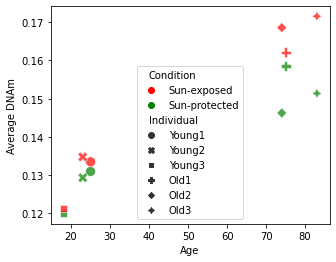

In [34]:
p=pd.DataFrame(hz[sep].mean())
p['age']=[25,23,18,75,74,83]+[25,23,18,75,74,83]
p['g']= ['Sun-protected']*6+['Sun-exposed']*6
p['indivudal']=2*['Young1','Young2','Young3','Old1','Old2','Old3']
p.columns=['Average DNAm','Age','Condition','Individual']
fig, ax = plt.subplots(figsize=(5,4))
sns.scatterplot(data=p,x='Age',y='Average DNAm',hue='Condition',hue_order=['Sun-exposed','Sun-protected'],
                palette=['red','green'],markers=True, style='Individual',s=100,alpha=.7)

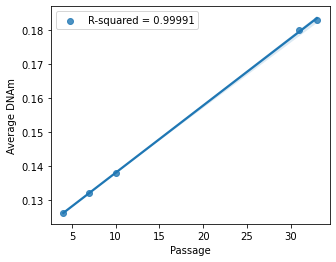

In [37]:
p=pd.DataFrame(hz[fs].mean())
p['Passage']=[4,7,10,31,33]
p.columns=['Average DNAm','Passage']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(5,4))
ax=sns.regplot(data=p,x='Passage',y='Average DNAm',label='R-squared = 0.99991')
ax.legend(loc="best")

In [28]:
p.corr()

,Average DNAm,Passage
Average DNAm,1.00000,0.99991
Passage,0.99991,1.00000


[Text(0, 0.5, 'DNA Methylation')]

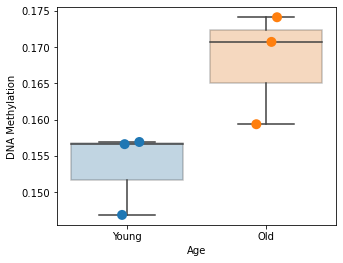

In [118]:
p=pd.DataFrame(hz[fyo].mean())
p['Age']=3*['Young']+3*['Old']
#p.columns=['Average DNAm','Passage']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(5,4))
ax=sns.boxplot(data=p,x='Age',y=0,boxprops=dict(alpha=.3))
ax=sns.stripplot(data=p,x='Age',y=0,marker=".",size=20)
ax.set( ylabel='DNA Methylation')